In [23]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import image_dataset_from_directory, to_categorical
import matplotlib.pyplot as plt


In [24]:
train_dir = "/Users/mayur/Downloads/DL for AI/cifar-10-img/train"
test_dir  = "/Users/mayur/Downloads/DL for AI/cifar-10-img/test"

train_ds = image_dataset_from_directory(
    train_dir,
    image_size=(32, 32),
    color_mode="rgb",
    batch_size=5000,
    shuffle=True
)

test_ds = image_dataset_from_directory(
    test_dir,
    image_size=(32, 32),
    color_mode="rgb",
    batch_size=1000,
    shuffle=True
)

# Extract all images into arrays
x_train, y_train = next(iter(train_ds.unbatch().batch(5000)))
x_test, y_test   = next(iter(test_ds.unbatch().batch(1000)))

# Convert labels to categorical
y_train = to_categorical(y_train, 10)
y_test  = to_categorical(y_test, 10)

# Normalize
x_train = x_train / 255.0
x_test  = x_test / 255.0


Found 40079 files belonging to 10 classes.
Found 9921 files belonging to 10 classes.


In [25]:
weights_path = "/Users/mayur/Downloads/DL for AI/vgg/vgg16_weights_tf_dim_ordering_tf_kernels_notop (1).h5"

base_model = VGG16(
    weights=weights_path,
    include_top=False,
    input_shape=(32, 32, 3)
)


In [26]:
for layer in base_model.layers:
    layer.trainable = False


In [27]:
# ---------------------------------------------------
# e) Fine-tune: unfreeze more layers
# ---------------------------------------------------
# Unfreeze last 50 layers

x = Flatten()(base_model.output)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
outputs = Dense(10, activation='softmax')(x)

# Final Model
model = Model(inputs=base_model.input, outputs=outputs)


In [28]:

model.compile(
    optimizer=Adam(),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [14]:
history = model.fit(
    x_train,
    y_train,
    batch_size=64,
    epochs=10,
    validation_data=(x_test, y_test)
)


Epoch 1/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 9s 114ms/step - accuracy: 0.2208 - loss: 2.1557 - val_accuracy: 0.4350 - val_loss: 1.6244
Epoch 2/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 9s 117ms/step - accuracy: 0.4118 - loss: 1.6254 - val_accuracy: 0.4770 - val_loss: 1.4905
Epoch 3/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 9s 119ms/step - accuracy: 0.4775 - loss: 1.4799 - val_accuracy: 0.5070 - val_loss: 1.4469
Epoch 4/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 9s 120ms/step - accuracy: 0.5200 - loss: 1.3642 - val_accuracy: 0.5010 - val_loss: 1.4060
Epoch 5/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 10s 123ms/step - accuracy: 0.5409 - loss: 1.2971 - val_accuracy: 0.5050 - val_loss: 1.4209
Epoch 6/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 10s 123ms/step - accuracy: 0.5567 - loss: 1.2450 - val_accuracy: 0.5160 - val_loss: 1.3744
Epoch 7/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 10s 124ms/step - accuracy: 0.5983 - loss: 1.1815 - val_accuracy: 0.5200 - val_loss: 1.3665
Epoch 8/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 10s 126ms/step - accuracy: 0.6160 - loss: 1.1037 - val_accuracy

In [15]:
# Reload VGG16
base_model = VGG16(
    weights=weights_path,
    include_top=False,
    input_shape=(32, 32, 3)
)

# Freeze all layers
for layer in base_model.layers:
    layer.trainable = False

# Unfreeze last 4 layers for fine-tuning
for layer in base_model.layers[-4:]:
    layer.trainable = True


In [16]:
x = Flatten()(base_model.output)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.3)(x)
outputs = Dense(10, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=outputs)


In [17]:
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [18]:
model.fit(
    x_train,
    y_train,
    batch_size=64,
    epochs=10,
    validation_data=(x_test, y_test)
)


Epoch 1/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 16s 202ms/step - accuracy: 0.1950 - loss: 2.1763 - val_accuracy: 0.4990 - val_loss: 1.4240
Epoch 2/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 16s 207ms/step - accuracy: 0.5164 - loss: 1.3955 - val_accuracy: 0.5680 - val_loss: 1.2243
Epoch 3/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 17s 209ms/step - accuracy: 0.6105 - loss: 1.1207 - val_accuracy: 0.5960 - val_loss: 1.1683
Epoch 4/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 17s 210ms/step - accuracy: 0.6751 - loss: 0.9520 - val_accuracy: 0.6170 - val_loss: 1.0656
Epoch 5/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 17s 212ms/step - accuracy: 0.7077 - loss: 0.8230 - val_accuracy: 0.6290 - val_loss: 1.0823
Epoch 6/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 17s 211ms/step - accuracy: 0.7781 - loss: 0.6615 - val_accuracy: 0.6440 - val_loss: 1.0498
Epoch 7/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 17s 213ms/step - accuracy: 0.8189 - loss: 0.5213 - val_accuracy: 0.6370 - val_loss: 1.1460
Epoch 8/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 17s 219ms/step - accuracy: 0.8539 - loss: 0.4338 - val_accu

32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step


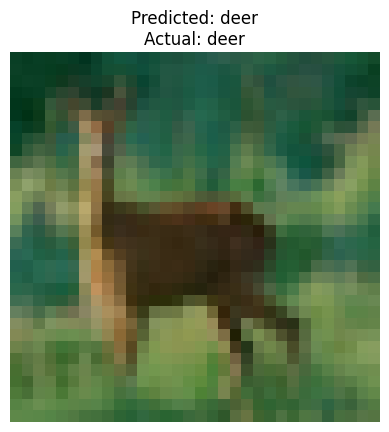

In [22]:
predicted = model.predict(x_test)
#define class_names
class_names = train_ds.class_names
labels = class_names

n = 5  # any index
plt.imshow(x_test[n])
plt.title(f"Predicted: {labels[np.argmax(predicted[n])]}\nActual: {labels[np.argmax(y_test[n])]}")
plt.axis('off')
plt.show()
